# Rasterizing vectors & vectorizing rasters <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[wofs_annual_summary](https://explorer.sandbox.dea.ga.gov.au/wofs_annual_summary)

## Background

Many remote sensing and/or geospatial workflows require converting between vector data (e.g. shapefiles) and raster data (e.g. pixel-based data like that in an `xarray.DataArray`).
For example, we may need to use a shapefile as a mask to limit the analysis extent of a raster, or have raster data that we want to convert into vector data to allow for easy geometry operations.

## Description
This notebook demonstrates the use of the DEA function `xr_rasterize` and `xr_vectorize` in [Scripts/dea_spatialtools.py](../Scripts/dea_spatialtools.py). 

The first section loads in [Water Observations from Space (WOfS)](https://www.ga.gov.au/scientific-topics/community-safety/flood/wofs/about-wofs) data from Digital Earth Australia, and vectorises the pixel-based `xarray.DataArray` object into a vector-based `geopandas.GeoDataFrame` object containing persistent water-bodies as polygons. 
We then export the `GeoDataframe` as a shapefile.  

The second section rasterises the vector data we created in the first section back into an `xarray.DataArray`, and exports the results as a GeoTIFF.

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [1]:
%matplotlib inline

import sys
import datacube

sys.path.append("../Scripts")
from dea_spatialtools import xr_vectorize, xr_rasterize

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app='Rasterize_vectorize')

## Load WOfS data from the datacube

We will load in an annual summary from the [Water Observations from Space (WOfS)](https://www.ga.gov.au/scientific-topics/community-safety/flood/wofs/about-wofs) product to provide us with some data to work with. The query below will load the 2000 annual summary of WOfS for the region around the Menindee Lakes.

In [3]:
# Create a query object
query = {
    'x': (142.1, 142.80),
    'y': (-32.1, -32.6),
    'time': ('2000')
}

# Load WoFS through the datacube
ds = dc.load(product='wofs_annual_summary', 
             **query)

print(ds)


<xarray.Dataset>
Dimensions:      (time: 1, x: 2789, y: 2443)
Coordinates:
  * time         (time) datetime64[ns] 2000-01-01
  * y            (y) float64 -3.536e+06 -3.536e+06 ... -3.597e+06 -3.597e+06
  * x            (x) float64 9.396e+05 9.396e+05 ... 1.009e+06 1.009e+06
Data variables:
    count_wet    (time, y, x) int16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    count_clear  (time, y, x) int16 24 24 23 23 23 24 24 ... 12 12 12 12 12 12
    frequency    (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    crs:      EPSG:3577


### Plot the WOfS summary

Let's plot the WOfS data to get an idea of the objects we will be transforming. 
In the code below, we first select the pixels where the satellite has observed water at least 25% of the year, this is so we can isolate the more persistent water bodies and reduce some of the noise before we vectorize the raster.

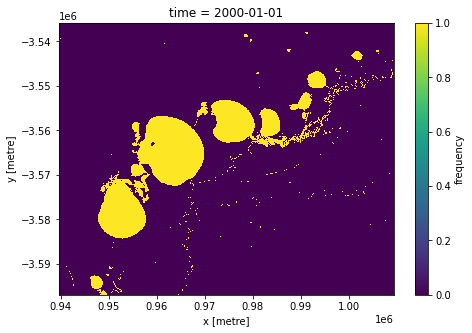

In [4]:
# Select pixels that are classified as water > 25 % of the time
water_bodies = ds.frequency > 0.25

# Plot the data
water_bodies.plot(size=5)

## Vectorizing an `xarray.DataArray`

To convert our xarray.DataArray object into a vector based `geopandas geodataframe`, we can use the DEA function `xr_vectorize` in the script [Scripts/dea_spatialtools.py](../Scripts/dea_spatialtools.py). This tool is based on the [rasterio.features.shape](https://rasterio.readthedocs.io/en/stable/api/rasterio.features.html) function, and can accept any of the arguments in `rasterio.features.shape` using the same syntax.

In the cell below, we use the argument `mask=water_bodies.values==1` to indicate we only want to convert the values in the xarray object that are equal to 1.

In [5]:
gdf = xr_vectorize(water_bodies,
                   crs=ds.crs,
                   mask=water_bodies.values==1)

print(gdf)

      attribute                                           geometry
0           1.0  POLYGON ((943150.000 -3535850.000, 943150.000 ...
1           1.0  POLYGON ((950575.000 -3535900.000, 950575.000 ...
2           1.0  POLYGON ((942800.000 -3535850.000, 942800.000 ...
3           1.0  POLYGON ((1000550.000 -3535850.000, 1000550.00...
4           1.0  POLYGON ((942950.000 -3535850.000, 942950.000 ...
...         ...                                                ...
1344        1.0  POLYGON ((947025.000 -3592675.000, 947025.000 ...
1345        1.0  POLYGON ((939950.000 -3596875.000, 939950.000 ...
1346        1.0  POLYGON ((950575.000 -3596875.000, 950575.000 ...
1347        1.0  POLYGON ((939975.000 -3596900.000, 939975.000 ...
1348        1.0  POLYGON ((964625.000 -3596700.000, 964625.000 ...

[1349 rows x 2 columns]


/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


### Plot our vectorised raster 

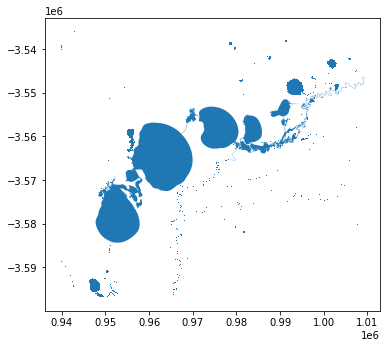

In [6]:
gdf.plot(figsize=(6, 6))

### Export as shapefile

Our function also allows us to very easily export the `GeoDataFrame` as a `shapefile`for use in other applications using the `export_shp` parameter:

In [7]:
gdf = xr_vectorize(da=water_bodies,
                   crs=ds.crs,
                   mask=water_bodies.values == 1.,
                   export_shp='test.shp')


/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


***
## Rasterizing a shapefile

Using the `xr_rasterize` function in [Scripts/dea_spatialtools.py](../Scripts/dea_spatialtools.py) (based on the rasterio function: [rasterio.features.rasterize](https://rasterio.readthedocs.io/en/stable/api/rasterio.features.html), and can accept any of the arguments in `rasterio.features.rasterize` using the same syntax) we can turn the `geopandas.GeoDataFrame` back into a `xarray.Dataset`. 

As we already have the `GeoDataFrame` loaded we don't need to read in the shapefile, but if we wanted to read in a shapefile first we can use [gpd.read_file()](http://geopandas.org/reference/geopandas.read_file.html).   

This function uses an `xarray.datarray` object as a template for converting the geodataframe into a raster object (the template provides the size, crs, dimensions, and attributes of the output array).

In [8]:
water_bodies_again = xr_rasterize(gdf=gdf,
                                  da=water_bodies,
                                  crs=ds.crs)

print(water_bodies_again)

Rasterizing to match xarray.DataArray dimensions (2443, 2789) and projection system/CRS (e.g. EPSG:3577)
<xarray.DataArray (y: 2443, x: 2789)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Coordinates:
  * y        (y) float64 -3.536e+06 -3.536e+06 ... -3.597e+06 -3.597e+06
  * x        (x) float64 9.396e+05 9.396e+05 9.397e+05 ... 1.009e+06 1.009e+06
Attributes:
    crs:      EPSG:3577


We can plot out rasterised data to verify it looks identical to the `water_bodies` data we previously plotted:

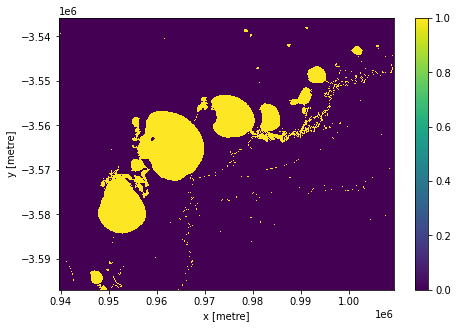

In [9]:
water_bodies_again.plot(size=5)

### Export as GeoTIFF

`xr_rasterize` also allows for exporting the results as a GeoTIFF.  To do this, a named array is required. If a name is not provided using the `name` parameter, the function will provide a default name.

In [10]:
water_bodies_again = xr_rasterize(gdf=gdf,
                                  da=water_bodies,
                                  crs=ds.crs,
                                  export_tiff='test.tif')


Rasterizing to match xarray.DataArray dimensions (2443, 2789) and projection system/CRS (e.g. EPSG:3577)
Exporting GeoTIFF to test.tif


---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** April 2020

**Compatible datacube version:** 

In [11]:
print(datacube.__version__)

1.7+262.g1cf3cea8


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)